In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import h5py
import numpy as np
from models.data import data_partition
from matplotlib import pyplot as plt

# Read data

In [118]:
with h5py.File("local_data/re100/ux.h5",'r') as hf:
    ux = np.array(hf.get("ux"))
with h5py.File("local_data/re100/uy.h5",'r') as hf:
    uy = np.array(hf.get("uy"))
with h5py.File("local_data/re100/pp.h5",'r') as hf:
    pp = np.array(hf.get("pp"))

In [119]:
ux = np.delete(ux,np.s_[:132],1)
uy = np.delete(uy,np.s_[:132],1)
pp = np.delete(pp,np.s_[:132],1)

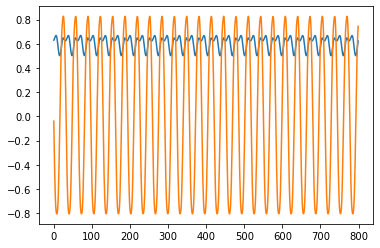

In [120]:
plt.figure()
plt.plot(ux[:,300,60])
plt.plot(uy[:,300,60])
plt.show()

In [121]:
# ux_train,ux_test 
[ux_train,ux_test] = data_partition(ux,0,[700,100],REMOVE_MEAN=True)
uy_train,uy_test = data_partition(uy,0,[700,100],REMOVE_MEAN=True)
pp_train,pp_test= data_partition(pp,0,[700,100],REMOVE_MEAN=True)

In [6]:
p_base = pp_train[:,0,49:80] # input

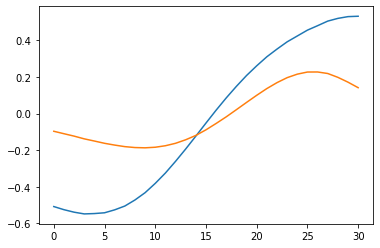

In [7]:
plt.figure()
plt.plot(p_base[30,:])
plt.plot(p_base[0,:])

plt.show()

# Train

In [8]:
import jax.numpy as jnp
import haiku as hk
import jax

In [9]:
ux_train = jnp.array(jnp.reshape(ux_train,(700,-1)))
p_base = jnp.array(p_base)

In [70]:
def feedforward(x):
    mlp = hk.nets.MLP([200,500,381*129],
                        activation=jax.nn.tanh,
                        w_init=hk.initializers.VarianceScaling(1.0,"fan_avg","uniform"))
    return mlp(x)

mdl = hk.transform(feedforward)
mdl = hk.without_apply_rng(mdl)

In [67]:
from typing import NamedTuple


class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

In [71]:
rng = jax.random.PRNGKey(1)

params = mdl.init(rng,p_base[0,:])

optimizer = optax.adamw(3e-4, weight_decay=1e-5)
opt_state = optimizer.init(params)

state = TrainingState(params, opt_state)

In [69]:

mdl = hk.without_apply_rng(mdl)

In [20]:
for layer_name, weights in params.items():
    print(weights['w'].shape)
    print(weights['b'].shape)

(31, 200)
(200,)
(200, 500)
(500,)
(500, 49149)
(49149,)


In [51]:
import optax

In [72]:
@jax.jit
def loss(params,x,y):
    pred = mdl.apply(params,x)
    l = jnp.mean((pred - y)**2)

    return l

In [74]:
# @jax.jit
# def update(weights,gradient):
#     return weights - 0.1 * gradient


@jax.jit
def update(state: TrainingState, x, y):

    l, grads = jax.value_and_grad(loss)(state.params, x, y)

    updates, opt_state = optimizer.update(grads, state.opt_state, state.params)
    params = optax.apply_updates(state.params, updates)

    return l, TrainingState(params, opt_state)

In [75]:
loss_train = []

In [109]:
best_state = state
min_loss = np.inf
for i in range(100001,120_001):
    # l, gradient = jax.value_and_grad(loss,argnums=0)(params,p_base,ux_train)
    # params = jax.tree_util.tree_map(update,params,gradient)

    l, state = update(state, p_base, ux_train)
    loss_train.append(l)
    
    if l < min_loss:
        best_state = state
        min_loss = l

    if i%200 == 0:
        print(f'epoch: {i}, loss: {l:.7f}')

epoch: 100200, loss: 0.0093674
epoch: 100400, loss: 0.0093608
epoch: 100600, loss: 0.0093296
epoch: 100800, loss: 0.0093356
epoch: 101000, loss: 0.0093123
epoch: 101200, loss: 0.0093342
epoch: 101400, loss: 0.0093715
epoch: 101600, loss: 0.0092448
epoch: 101800, loss: 0.0092054
epoch: 102000, loss: 0.0091863
epoch: 102200, loss: 0.0091639
epoch: 102400, loss: 0.0091838
epoch: 102600, loss: 0.0091260
epoch: 102800, loss: 0.0091120
epoch: 103000, loss: 0.0091016
epoch: 103200, loss: 0.0090652
epoch: 103400, loss: 0.0090453
epoch: 103600, loss: 0.0090867
epoch: 103800, loss: 0.0091087
epoch: 104000, loss: 0.0089874
epoch: 104200, loss: 0.0089734
epoch: 104400, loss: 0.0089601
epoch: 104600, loss: 0.0089383
epoch: 104800, loss: 0.0089128
epoch: 105000, loss: 0.0088914
epoch: 105200, loss: 0.0088770
epoch: 105400, loss: 0.0088546
epoch: 105600, loss: 0.0088617
epoch: 105800, loss: 0.0088141
epoch: 106000, loss: 0.0087997
epoch: 106200, loss: 0.0087725
epoch: 106400, loss: 0.0087531
epoch: 1

In [110]:
state = best_state

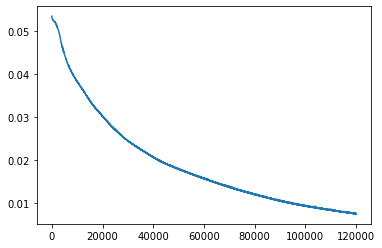

In [111]:
plt.figure()
plt.plot(loss_train)
plt.show()

In [98]:
preds = mdl.apply(state.params, p_base)
preds_reshape = np.reshape(preds,(700,-1,129))

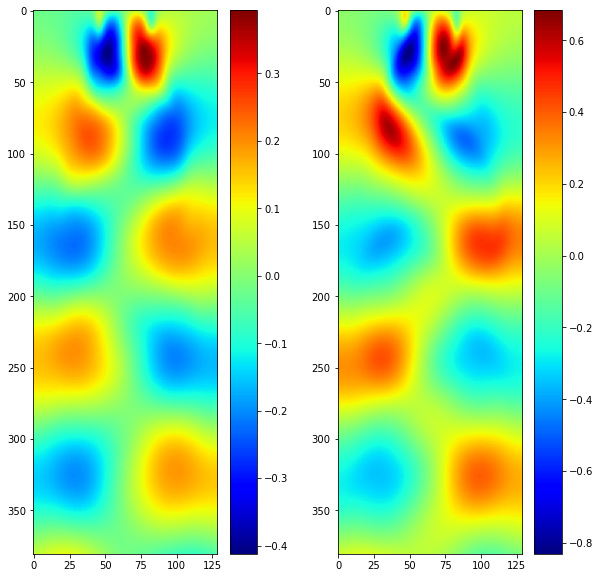

In [107]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
im1 = ax[0].imshow(preds_reshape[30,...],'jet')
im2 = ax[1].imshow(np.reshape(ux_train[30,...],(-1,129)),'jet')
fig.colorbar(im1,ax=ax[0])
fig.colorbar(im2,ax=ax[1])
plt.show()

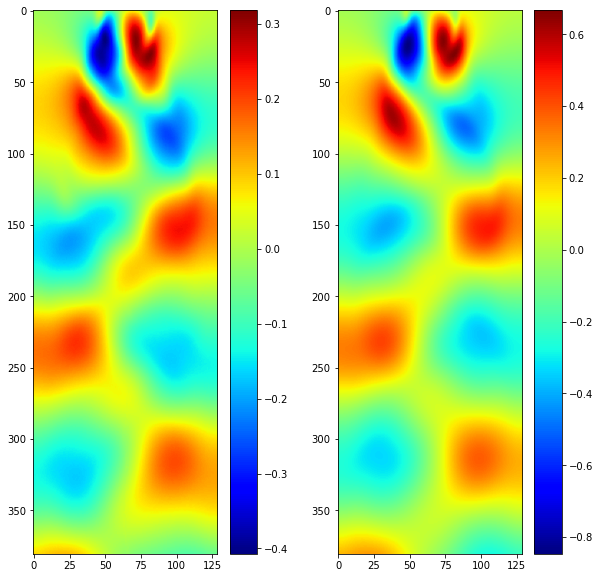

In [108]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
im1 = ax[0].imshow(preds_reshape[0,...],'jet')
im2 = ax[1].imshow(np.reshape(ux_train[0,...],(-1,129)),'jet')
fig.colorbar(im1,ax=ax[0])
fig.colorbar(im2,ax=ax[1])
plt.show()